In [1]:
# import libraries
import  torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import  os
import  logging
import  numpy as np
from pathlib import  Path
import matplotlib.pyplot as plt
from  datetime import  datetime

# set seed 
torch.manual_seed(42)

/home/jason/anaconda3/envs/tadac/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class EarlyStopping():
    def __init__(self, verbose: bool = False, filepath: str = "checkpoint.pt", patience: int = 10, delta: float = 0) -> None:
        
        self.verbose = verbose
        self.patience = patience
        self.filepath = filepath
        self.delta = delta

        self.is_early_stopping = False
        self.best_score = None
        self.counter = 0
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        
        if self.best_score is None:
            self.best_score = val_loss
        elif self.best_score + self.delta < val_loss:
            self.counter += 1
            logging.info(f"Early stopping {self.counter} out of {self.patience}...")

            if self.counter >= self.patience:
                self.is_early_stopping = True
        else: 
            self.save_checkpoint(model, val_loss)
            self.best_score = val_loss
            self.counter = 0

        
        
    def save_checkpoint(self, model, val_loss):

        if self.verbose:
            logging.info(f"Validation loss decreased from {self.val_loss_min:0.5f} -> {val_loss}")
            logging.info(f"The model is saved in this path {self.filepath}")    

        torch.save(model.state_dict(), self.filepath)
        self.val_loss_min = val_loss


In [3]:
# data dir
DATA_DIR = Path('../../data')
if not DATA_DIR.is_dir():
    DATA_DIR.mkdir(parents=True, exist_ok=True)

# checkpoint dir
SAVED_MODELS_DIR = Path('../../models')
if not SAVED_MODELS_DIR.is_dir():
    SAVED_MODELS_DIR.mkdir(parents=True, exist_ok=True)
    
# log dir
LOG_DIR = Path('../../logs')
if not LOG_DIR.is_dir():
    LOG_DIR.mkdir(parents=True, exist_ok=True)
    

In [4]:
logging.basicConfig(
    level=logging.INFO,
    datefmt="%a, %d %b %Y %H:%M:%S",
    format="[%(asctime)s.%(msecs)03d] %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(filename=LOG_DIR.joinpath(f"04_earlystopping_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"), mode="w"),
        logging.StreamHandler()
    ]
)

In [5]:
def create_datasets(batch_size):

    # percentage of training set to use as validation
    valid_size = 0.2

    # convert data to torch.FloatTensor
    transform = transforms.ToTensor()

    # choose the training and test datasets
    train_data = datasets.MNIST(root=DATA_DIR, 
                                train=True,
                                download=True, 
                                transform=transform)

    test_data = datasets.MNIST(root=DATA_DIR,
                               train=False,
                               download=True,
                               transform=transform)

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)
    
    return train_loader, test_loader, valid_loader

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
mnist_model = Net()
print(mnist_model)
type(mnist_model)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


__main__.Net

In [7]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(mnist_model.parameters())

In [8]:
def train_model(model, batch_size, patience, n_epochs, train_loader, valid_loader):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # file_path
    FILE_PATH = SAVED_MODELS_DIR.joinpath('checkpoint.pt')
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True, filepath=FILE_PATH)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        logging.info(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.is_early_stopping:
            logging.info("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(SAVED_MODELS_DIR.joinpath('checkpoint.pt')))

    return  model, avg_train_losses, avg_valid_losses

In [9]:
batch_size = 256
n_epochs = 100

train_loader, test_loader, valid_loader = create_datasets(batch_size)

# early stopping patience; how long to wait after last time validation loss improved.
patience = 20

model, train_loss, valid_loss = train_model(mnist_model, batch_size, patience, n_epochs, train_loader, valid_loader)

[Sat, 29 Jul 2023 01:15:54.040] INFO - [  1/100] train_loss: 0.84470 valid_loss: 0.30377
[Sat, 29 Jul 2023 01:15:57.087] INFO - [  2/100] train_loss: 0.36941 valid_loss: 0.22500
[Sat, 29 Jul 2023 01:15:57.087] INFO - Validation loss decreased from inf -> 0.22500327768477987
[Sat, 29 Jul 2023 01:15:57.088] INFO - The model is saved in this path ../../models/checkpoint.pt
[Sat, 29 Jul 2023 01:16:00.238] INFO - [  3/100] train_loss: 0.29773 valid_loss: 0.18974
[Sat, 29 Jul 2023 01:16:00.238] INFO - Validation loss decreased from 0.22500 -> 0.1897373227997029
[Sat, 29 Jul 2023 01:16:00.239] INFO - The model is saved in this path ../../models/checkpoint.pt
[Sat, 29 Jul 2023 01:16:03.430] INFO - [  4/100] train_loss: 0.25621 valid_loss: 0.16833
[Sat, 29 Jul 2023 01:16:03.430] INFO - Validation loss decreased from 0.18974 -> 0.168327215979708
[Sat, 29 Jul 2023 01:16:03.431] INFO - The model is saved in this path ../../models/checkpoint.pt
[Sat, 29 Jul 2023 01:16:06.595] INFO - [  5/100] train

[Sat, 29 Jul 2023 01:18:20.838] INFO - The position of the lowest validation loss: 28


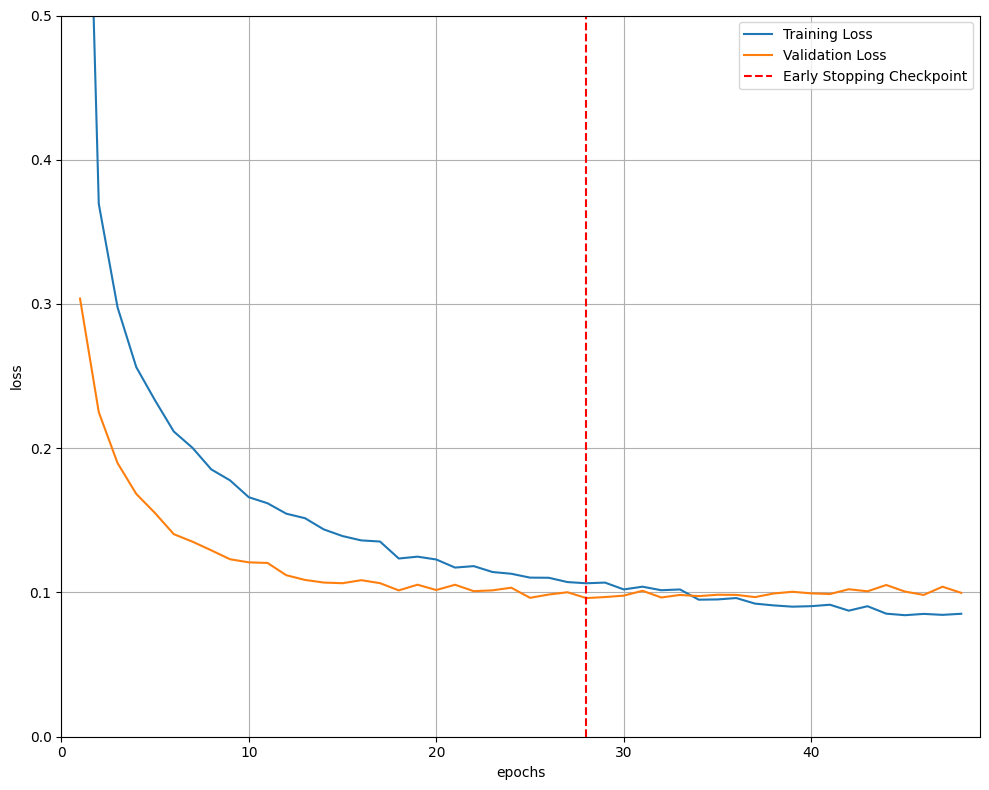

In [10]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
lowest_val_loss = valid_loss.index(min(valid_loss))+1 
logging.info(f"The position of the lowest validation loss: {lowest_val_loss}")

plt.axvline(lowest_val_loss, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(LOG_DIR.joinpath('loss_plot.png'), bbox_inches='tight')

In [11]:
classes = [str(i) for i in np.arange(0,10)]
classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [14]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    if len(target.data) != batch_size:
        break
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
logging.info('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        logging.info('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        logging.info('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

logging.info('Test Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

[Sat, 29 Jul 2023 01:24:14.372] INFO - Test Loss: 0.092405

[Sat, 29 Jul 2023 01:24:14.372] INFO - Test Accuracy of     0: 98% (969/979)
[Sat, 29 Jul 2023 01:24:14.373] INFO - Test Accuracy of     1: 98% (1117/1133)
[Sat, 29 Jul 2023 01:24:14.373] INFO - Test Accuracy of     2: 97% (1003/1030)
[Sat, 29 Jul 2023 01:24:14.374] INFO - Test Accuracy of     3: 97% (979/1008)
[Sat, 29 Jul 2023 01:24:14.374] INFO - Test Accuracy of     4: 98% (961/980)
[Sat, 29 Jul 2023 01:24:14.374] INFO - Test Accuracy of     5: 97% (867/890)
[Sat, 29 Jul 2023 01:24:14.375] INFO - Test Accuracy of     6: 97% (931/956)
[Sat, 29 Jul 2023 01:24:14.375] INFO - Test Accuracy of     7: 96% (996/1027)
[Sat, 29 Jul 2023 01:24:14.375] INFO - Test Accuracy of     8: 95% (933/973)
[Sat, 29 Jul 2023 01:24:14.376] INFO - Test Accuracy of     9: 95% (964/1008)
[Sat, 29 Jul 2023 01:24:14.376] INFO - Test Accuracy (Overall): 97% (9720/9984)


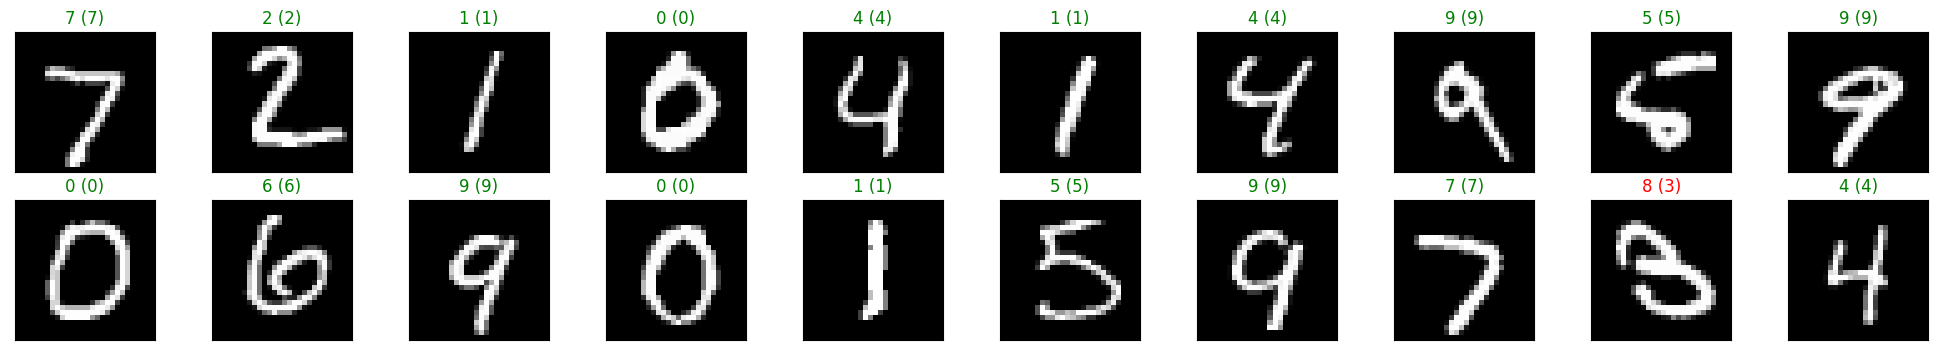

In [15]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

#### References

The MNIST training example code is mainly taken from the [mnist_mlp_solution_with_validation.ipynb](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/mnist-mlp/mnist_mlp_solution_with_validation.ipynb) notebook from the [deep-learning-v2-pytorch repository](https://github.com/udacity/deep-learning-v2-pytorch) made by [Udacity](https://www.udacity.com/), and has been fitted with my early stopping code. 